# Solución de Tarea 2

## El enunciado de esta tarea se encuentra [acá](https://estudianteccr-my.sharepoint.com/:b:/g/personal/prof_juan_rojas_estudiantec_cr/EdId4HEXT1ZKu_CcYqp8Xf8B7jW8GP4yU-h0etowk2Nqyw)

Primero se incluyen los paquetes necesarios, *csv*, *numpy* y *matplotlib* 

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

Luego se crean un par de vectores para nuestros datos de $SOC$ y $OCV$

In [2]:
soc = np.array([])
ocv = np.array([])

Ahora:
* se abre el archivo *OCV(z).csv* en modo de solo lectura *r*
* se imprime la primera fila, que tiene los títulos
* se ingresa en el loop dejando afuera la primera fila y se van anexando los datos en las matrices

In [3]:
with open("OCV(z).csv", mode="r")as file:
    read = csv.reader(file)
    print("Los títulos de las columnas son:")
    print(next(read))
    for row in read:
        soc = np.append(soc,float(row[0]))
        ocv = np.append(ocv,float(row[1]))

Los títulos de las columnas son:
['SOC', 'OCV']


Luego se grafican los datos usando matlibplot

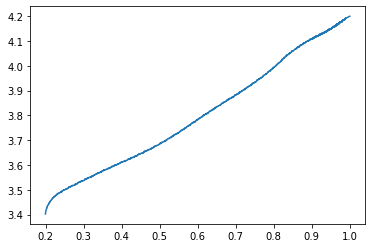

In [4]:
plt.plot(soc,ocv)
plt.show()

Ahora se define la función que se usa para interpolar

In [5]:
def ocv_value(soc_values, ocv_values, input_soc):
    "devuelve el valor del OCV para cualquier SOC"
    output_ocv = 0
    for i in range(len(soc_values)):
        if input_soc <= soc_values[i]: # si 
            if soc_values[i-1] == soc_values[i]:
                output_ocv = ocv_values[i]
                break
            output_ocv = ocv_values[i-1] + (ocv_values[i]-ocv_values[i-1])*((input_soc - soc_values[i-1])/(soc_values[i] - soc_values[i-1]))
            break
    return output_ocv

Ahora 
* se crea un vector lineal de $SOC$ para interpolar, con 10 valores de 0.2 a 1 para probar la función de interpolación 
* se define un vector de $OCV$ para tomar el resultado de la interpolación
* se realiza un bucle *for* para ir realizando la interpolación usando como entrada los 10 valores de $SOC$

In [6]:
soc_int = np.linspace(0.2, 1, num=10)
ocv_int = np.array([])
for i in range(len(soc_int)):
    ocv_int = np.append(ocv_int,ocv_value(soc,ocv,soc_int[i]))

Luego se realiza un gráfico con los valores del *.csv* y los 10 valores interpolados para estar seguros que funciona correctamente

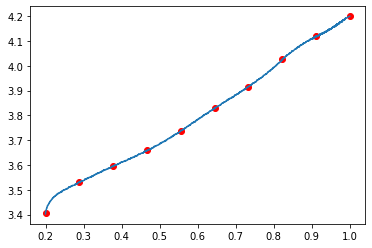

In [7]:
plt.plot(soc_int,ocv_int,'or',soc,ocv)
plt.show()

Luego se definen los valores inciales de $z(k)$, $v(k)$, $i(k)$ y $t(k)$

In [8]:
# Valores iniciales
z_0 = 0.2
v_0 = ocv_value(soc,ocv,z_0) # al inicio no hay corriente por lo que el voltaje es igual al OCV(z)
i_0 = 0
t_0 = 0

Se definen los vectores de esas mismas variables con los valores iniciales

In [9]:
z = np.array([z_0])
v = np.array([v_0])
i = np.array([i_0])
t = np.array([t_0])

Se definen las constantes

In [10]:
Q = 3.250           # capacidad
CC_char = -0.5*Q    # corriente constante de carga negativa según Figura 1. 
CC_disc = Q         # corriente constante de descarga
CV = 4.2            # voltaje constante
EOC = -0.5          # "end of charge" 500 mA
EOD = 3.2           # "end of discharge" 3.2V
R_0 = 0.1           # resitencia

index = 0           # se inicia en cero, de forma que la primera vez que se llama la posición [index], sean los valores iniciales
eta_char = 0.99     # efficiencia de Coulumb para el proceso de carga
eta_disc = 1        # efficiencia de Coulumb para el proceso de carga
Dt = 0.5/3600       # intervalo discreto de tiempo (Delta t) en horas

iC_SOC = z[index]   #estado de carga inicial

Al aplicar LVK a la Figura 1. se obtiene:

$-OCV +i\cdot R_0 + v = 0$,

despejando $v$ tenemos que:

$v = OCV - i\cdot R_0$

también podemos despejar $i$ y obtener:

$i = \dfrac{OCV - v}{R_0}$


![Rint model](img/cell_model.png)

Ahora se inicia el proceso de carga a CC
* definimos la eficiencia de Coulumb
* definimos la corriente en CC para todos los instantes discretos
* definimos el estado de carga del instante siguiente con base en la integral discretizada:
    
$z[k+1] = z[k] - \dfrac{\eta \Delta t}{Q} i[k]$

* definimos el voltaje del instante siguiente con base en:
    
$v[k+1] = OCV(z[k+1]) - i[k+1]\cdot R_0$

* definimos en tiempo del instante siguiente con base en:

$t[k+1] = t[k] + \Delta t$


In [11]:
## Charging in CC
while v[index] < CV:
    eta = eta_char
    i = np.append(i,CC_char)    
    z = np.append(z,z[index] - (eta_char*Dt*i[index])/Q) 
    v = np.append(v,ocv_value(soc,ocv,z[index+1]) - i[index+1]*R_0) 
    t = np.append(t,t[index]+Dt)
    index += 1 

Luego de finalizado el proceso de carga a CC se pasa a carga a CV, los valores iniciales de este proceso son los valores finales del anterior
* definimos la eficiencia de Coulumb
* definimos el voltaje en CV para todos los instantes discretos
* definimos el estado de carga del instante siguiente con base en la integral discretizada:
    
$z[k+1] = z[k] - \dfrac{\eta \Delta t}{Q} i[k]$

* definimos la corriente del instante siguiente con base en:
    
$i[k+1] = \dfrac{OCV(z[k+1]) - v[k+1]}{R_0}$

* definimos en tiempo del instante siguiente con base en:

$t[k+1] = t[k] + \Delta t$

In [12]:
## Charging in CV
while i[index] < EOC:
    eta = eta_char 
    v = np.append(v,CV) #es negativo por estar en carga
    z = np.append(z,z[index] - (eta_char*Dt*i[index])/Q)   
    i = np.append(i,(ocv_value(soc,ocv,z[index+1]) - v[index+1])/R_0) 
    t = np.append(t,t[index]+Dt)
    index += 1
fC_SOC = z[index]

Por último, luego de finalizado el proceso de carga a CV se pasa a descarga a CC, los valores iniciales de este proceso son los valores finales del anterior
* definimos la eficiencia de Coulumb
* definimos la corriente en CC para todos los instantes discretos
* definimos el estado de carga del instante siguiente con base en la integral discretizada:
    
$z[k+1] = z[k] - \dfrac{\eta \Delta t}{Q} i[k]$

* definimos el voltaje del instante siguiente con base en:
    
$v[k+1] = OCV(z[k+1]) - i[k+1]\cdot R_0$

* definimos en tiempo del instante siguiente con base en:

$t[k+1] = t[k] + \Delta t$

In [13]:
## Discharging in CC
while v[index] > EOD:
    eta = eta_disc
    i = np.append(i,CC_disc)
    z = np.append(z,z[index] - (eta_char*Dt*i[index])/Q)   
    v = np.append(v,ocv_value(soc,ocv,z[index+1]) - i[index+1]*R_0) 
    t = np.append(t,t[index]+Dt)
    index += 1
fD_SOC = z[index]

Se genera el gráfico de voltaje en el tiempo

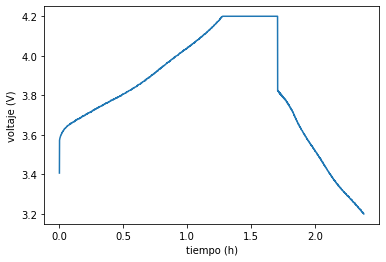

In [14]:
plt.plot(t,v)
plt.xlabel("tiempo (h)")
plt.ylabel("voltaje (V)")
plt.show()

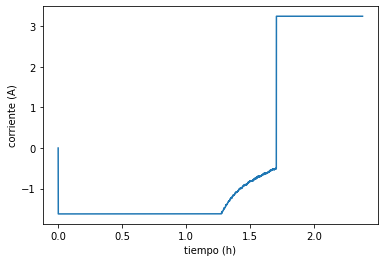

In [15]:
plt.plot(t,i)
plt.xlabel("tiempo (h)")
plt.ylabel("corriente (A)")
plt.show()


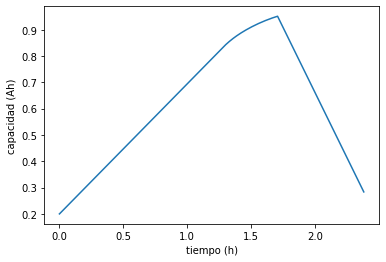

In [16]:
plt.plot(t,z)
plt.xlabel("tiempo (h)")
plt.ylabel("capacidad (Ah)")
plt.show()

In [28]:
print("El valor de SOC al incio de la carga es: ", end='\0') 
print("{0:.3f}".format(iC_SOC))
print("El valor de SOC al final de la carga es: ", end='\0') 
print("{0:.3f}".format(fC_SOC))
print("El valor de SOC al final de la descarga es: ", end='\0') 
print("{0:.3f}".format(fD_SOC))
print("La capacidad cargada: ", end='\0') 
print("{0:.3f}".format((fC_SOC - iC_SOC) * Q), end='\0')
print(" Ah")
print("La capacidad descargada: ", end='\0') 
print("{0:.3f}".format((fC_SOC - fD_SOC) * Q), end='\0')
print(" Ah")

El valor de SOC al incio de la carga es:  0.200
El valor de SOC al final de la carga es:  0.951
El valor de SOC al final de la descarga es:  0.284
La capacidad cargada:  2.441  Ah
La capacidad descargada:  2.169  Ah
